In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

import re

In [2]:
train = pd.read_csv('/content/Corona_NLP_train.csv',encoding='latin1')
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [3]:
train.shape

(41157, 6)

In [4]:
train=train[['OriginalTweet','Sentiment']]
train.head() 

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet) 
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    return tweet


stop_words = stopwords.words('english')

X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[6]))
print("\nAfter tokenizing :\n{}".format(X[6]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[6]))

Vocabulary size: 36117

Example:

Sentence:
Cashier grocery store sharing insights To prove credibility commented "I'm Civics class I know I'm talking about".

After tokenizing :
[1174, 7, 4, 1269, 761, 65, 2902, 9761, 9762, 154, 18316, 1501, 2, 62, 154, 900, 958]

After padding :
[ 1174     7     4  1269   761    65  2902  9761  9762   154 18316  1501
     2    62   154   900   958     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [9]:
y=y.replace({'Extremely Negative': 0,
            'Negative': 1,
            'Neutral': 2,
            'Positive':3,
            'Extremely Positive': 4})
y 

0        2
1        3
2        3
3        3
4        0
        ..
41152    2
41153    0
41154    3
41155    2
41156    1
Name: Sentiment, Length: 41157, dtype: int64

In [10]:
X.shape[1]

54

In [11]:
tf.keras.backend.clear_session()

# hyper parameters
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(5 , activation="softmax")
])

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 16)            577872    
                                                                 
 bidirectional (Bidirectiona  (None, 54, 512)          559104    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [12]:
history = model.fit(X, y, epochs=3, validation_split=0.12, batch_size=50) 

Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


725/725 [==============================] - 18s 15ms/step - loss: 1.3082 - accuracy: 0.4343 - val_loss: 0.8488 - val_accuracy: 0.6617
Epoch 2/3
725/725 [==============================] - 8s 12ms/step - loss: 0.7334 - accuracy: 0.7384 - val_loss: 0.6526 - val_accuracy: 0.7629
Epoch 3/3
725/725 [==============================] - 8s 12ms/step - loss: 0.5293 - accuracy: 0.8261 - val_loss: 0.6233 - val_accuracy: 0.7744


In [13]:
test = pd.read_csv('/content/Corona_NLP_test.csv',encoding='latin1')
test 

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [14]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

X_test = X_test.apply(data_cleaner)

# tokenizer.fit_on_texts(X_test)
X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post',maxlen=54)

y_test.replace({'Extremely Negative': 0,
            'Negative': 1,
            'Neutral': 2,
            'Positive': 3,
            'Extremely Positive': 4}, inplace=True)

In [15]:
y_test.values

array([0, 3, 4, ..., 2, 0, 4])

In [16]:
pred = model.predict(X_test)
pred

119/119 [==============================] - 1s 4ms/step


array([[7.02300370e-02, 9.04321671e-01, 1.08492207e-02, 1.41995624e-02,
        3.99522076e-04],
       [4.03056074e-05, 1.84445071e-03, 4.50339122e-03, 9.66619492e-01,
        2.69924551e-02],
       [2.06802597e-05, 1.32356246e-04, 9.17348079e-05, 1.10013396e-01,
        8.89741838e-01],
       ...,
       [7.33941342e-05, 3.36837978e-03, 9.85988617e-01, 1.03454608e-02,
        2.24092684e-04],
       [9.40283120e-01, 5.94741665e-02, 7.44302952e-06, 2.13979962e-04,
        2.12541563e-05],
       [2.89473319e-05, 1.60026539e-04, 8.13646984e-05, 6.35812506e-02,
        9.36148405e-01]], dtype=float32)

In [17]:
l=[]
for i in pred:
  l.append(np.argmax(i))
y_pred=np.array(l)

In [18]:
y_pred 

array([1, 3, 4, ..., 2, 0, 4])

In [19]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test.values),1)),1))

[[1 0]
 [3 3]
 [4 4]
 ...
 [2 2]
 [0 0]
 [4 4]]


[[403 179   4   5   1]
 [ 96 780  34 124   7]
 [  2  84 473  60   0]
 [ 15 122  11 766  33]
 [  2  17   0 203 377]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       592
           1       0.66      0.75      0.70      1041
           2       0.91      0.76      0.83       619
           3       0.66      0.81      0.73       947
           4       0.90      0.63      0.74       599

    accuracy                           0.74      3798
   macro avg       0.78      0.73      0.75      3798
weighted avg       0.76      0.74      0.74      3798



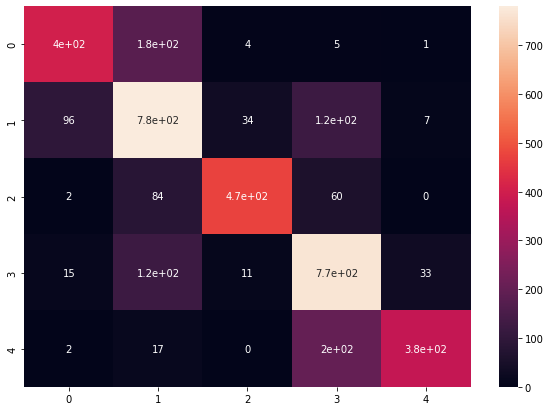

In [20]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,7))
print(cm)
print(sns.heatmap(cm , annot=True))
print(classification_report(y_test,y_pred))